<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-и-подготовка-данных-(ресемплирование)" data-toc-modified-id="Изучение-и-подготовка-данных-(ресемплирование)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение и подготовка данных (ресемплирование)</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Анализ-различных-моделей" data-toc-modified-id="Анализ-различных-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ различных моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Изучение и подготовка данных (ресемплирование)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.ensemble import RandomForestRegressor

/opt/anaconda3/envs/practicum/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Код для чтения данных
df_taxi = pd.read_csv('df_taxi.csv', parse_dates=[0], index_col=[0])  # Локальный путь

In [3]:
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# Проверим, в хронологическом ли порядке расположены даты и время
df_taxi.index.is_monotonic

True

In [6]:
# Выполним ресемплирование данных по одному часу, для этого посчитаем сумму заказов в час
df_taxi = df_taxi.resample('1H').sum()

In [7]:
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ данных

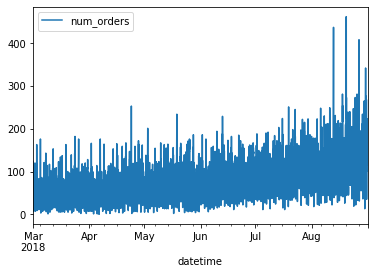

In [8]:
# Построим зависимость заказов от времени
df_taxi.plot();

График не информативный, добавим скользящее среднее в данные

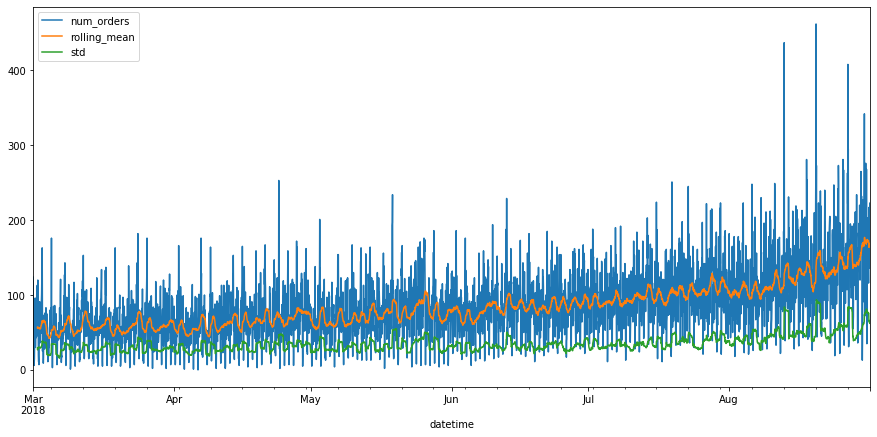

In [9]:
# Добавим в данные скользящее среднее за 24 часа
df_taxi_new = df_taxi.copy()
df_taxi_new['rolling_mean'] = df_taxi_new['num_orders'].rolling(24).mean()
df_taxi_new['std'] = df_taxi_new['num_orders'].rolling(24).std()
df_taxi_new.plot(figsize=(15, 7));

Видим, что за весь период времени среднее количество заказов растет. Кроме того можно сказать, что ряд нестационарный, так как среднее значение меняется, хотя стандартное отклонение при этом почти неизменно.

In [10]:
# Разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(df_taxi)

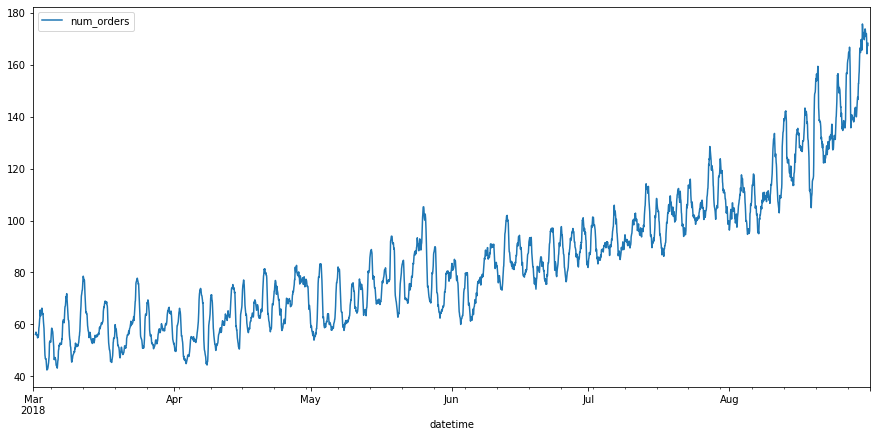

In [11]:
decomposed.trend.plot(figsize=(15, 7));

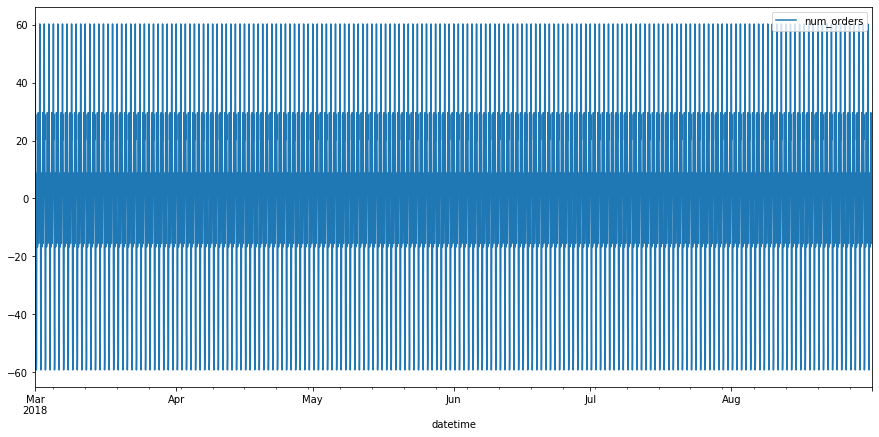

In [12]:
decomposed.seasonal.plot(figsize=(15, 7));

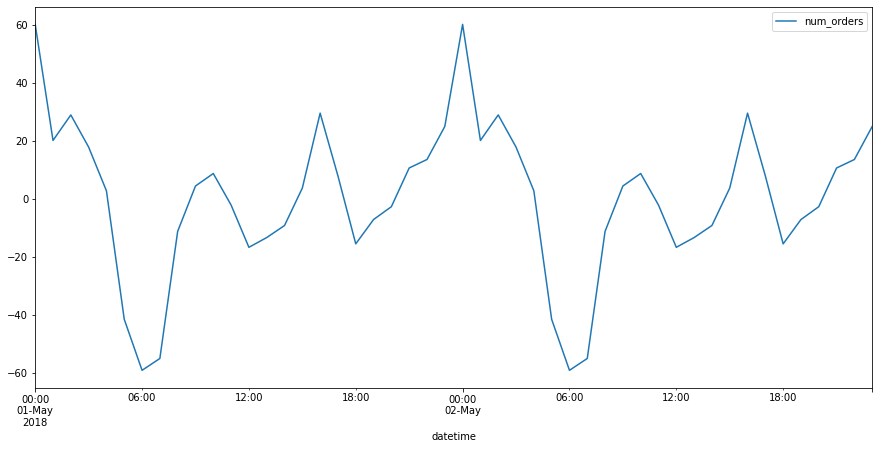

In [13]:
decomposed.seasonal['2018-05-01': '2018-05-02'].plot(figsize=(15, 7));

По тренду видим, что среднее значение растет на протяжении всего периода. По сезонности можно сказать, что больше всего заказов ночью, меньше всего в шесть утра!

## Анализ различных моделей

In [14]:
# Напишем функцию, которая создает дополнительные признаки: день, день недели, час, отставание в 1 час
# на определенное количество шагов. Кроме того функция обновляет скользящее среднее
# и удаляет столбец со стандартным отклонением
df_taxi_new_features = df_taxi_new.copy()
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.drop('std', axis=1)

In [15]:
make_features(df_taxi_new_features, 50, 24)

In [16]:
df_taxi_new_features.head()

,num_orders,rolling_mean,std,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,1,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,1,3,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,1,3,2,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,1,3,4,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Разделим данные на обучающую и тестовую выборки
train, valid_test = train_test_split(df_taxi_new_features, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)
train = train.dropna()

In [18]:
# Выделим переменные признаки и признак, который нужно предсказать
features_train = train.drop('num_orders', axis=1) # извлеките признаки
target_train = train['num_orders'] # извлеките целевой признак

features_valid = valid.drop('num_orders', axis=1) # извлеките признаки
target_valid = valid['num_orders'] # извлеките целевой признак

features_test = test.drop('num_orders', axis=1) # извлеките признаки
target_test = test['num_orders'] # извлеките целевой признак

features_valid_test = valid_test.drop('num_orders', axis=1) # извлеките признаки
target_valid_test = valid_test['num_orders'] # извлеките целевой признак

### Линейная регрессия

In [19]:
model = LinearRegression()
model.fit(features_train, target_train)
pred_valid = model.predict(features_valid)
pred_test = model.predict(features_test)                   
print('RMSE валидационной выборки:', mean_squared_error(pred_valid, target_valid)**0.5)
print('RMSE тестовой выборки:', mean_squared_error(pred_test, target_test)**0.5)

RMSE валидационной выборки: 31.466060197707463
RMSE тестовой выборки: 41.74484960927736


### LightGBM

In [20]:
model_lgbm = LGBMRegressor(random_state=12345)
params_lgbm = {'n_estimators' : [100, 200, 500],
               'max_depth' : range(2, 7),
               'num_leaves': [20, 30, 45]}

tscv = TimeSeriesSplit()
search_lgbm = GridSearchCV(estimator=model_lgbm, cv=tscv, param_grid=params_lgbm, scoring='neg_mean_squared_error',
                           verbose=0)
result_lgbm = search_lgbm.fit(features_train, target_train)

In [21]:
print('Лучшее значение RMSE в LightGBM:', round(abs(result_lgbm.best_score_)**0.5, 2))
print('Лучшие параметры LightGBM:', result_lgbm.best_params_)

Лучшее значение RMSE в LightGBM: 22.7
Лучшие параметры LightGBM: {'max_depth': 4, 'n_estimators': 200, 'num_leaves': 20}


In [22]:
# Проверим модель LightGBM на валидационной+тестовой выборках
model = result_lgbm.best_estimator_
model.fit(features_train, target_train)
pred_valid_test = model.predict(features_valid_test)
rmse = mean_squared_error(pred_valid_test, target_valid_test)**0.5
print("RMSE лучшей модели на валидационной+тестовой выборках:", rmse)

RMSE лучшей модели на валидационной+тестовой выборках: 41.5380017093039


### CatBoost

In [ ]:
model_cat = CatBoostRegressor(random_seed=12345)
params_cat = {'iterations' : [100, 300, 500, 1000],
              'depth' : range(2, 8)}

tscv = TimeSeriesSplit()
search_cat = GridSearchCV(estimator=model_cat, cv=tscv, param_grid=params_cat, scoring='neg_mean_squared_error');
result_cat = search_cat.fit(features_train , target_train)

In [27]:
print('Лучшее значение RMSE в CatBoost:', round(abs(result_cat.best_score_)**0.5, 2))
print('Лучшие параметры CatBoost:', result_cat.best_params_)

Лучшее значение RMSE в CatBoost: 22.09
Лучшие параметры CatBoost: {'depth': 5, 'iterations': 1000}


In [ ]:
# Проверим модель CatBoost на валидационной+тестовой выборках
model = result_cat.best_estimator_
model.fit(features_train, target_train)
pred_valid_test = model.predict(features_valid_test)
rmse = mean_squared_error(pred_valid_test, target_valid_test)**0.5

In [30]:
print("RMSE лучшей модели на валидационной+тестовой выборках:", rmse)

RMSE лучшей модели на валидационной+тестовой выборках: 41.05932191218579


Видим, что LightGBM и СatBoost лучше обучили модель, чем линейная регрессия, однако на тестовой выборке RMSE у всех одинаково, возможно LightGBM и СatBoost будут лучше предсказывать данные на следующий год, а не в пределах одного года.

## Выводы
- В ходе работы мы изучили данные и выполнили их ресемплирование по одному часу
- Проанализировали таблицу, добавили в данные скользящее среднее за 24 часа
- Написали функцию, которая создает дополнительные признаки: день, день недели, час, отставание в 1 час на определенное количество шагов, кроме того функция обновляет скользящее среднее и удаляет столбец со стандартным отклонением
- Обучили различные модели: линейную регрессию, LightGBM, CatBoost, и сравнили их RMSE
- LightGBM и СatBoost лучше обучили модель, чем линейная регрессия, однако на тестовой выборке RMSE у всех одинаково и равно 41